# **Proximal Policy Optimization**

Environment: Lunar Lander

## References

#### Papers
- [Proximal Policy Optimization Algorithms, Schulman et al. 2017](https://arxiv.org/abs/1707.06347)
- [Emergence of Locomotion Behaviours in Rich Environments, Heess et al. 2017](https://arxiv.org/abs/1707.02286)

#### Blogs
- [OpenAI Spinning Up - Proximal Policy Optimization](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

#### Others
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html)
- [OpenAI Gym](https://gym.openai.com/)

## Preparation

In [1]:
%%capture
!sudo apt update
!sudo apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay piglet tqdm

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook

In [3]:
# Import gym and create a Lunar Lander environment
# Observation/State: Box(8,)
# Action: Discrete(4)
%%capture
import gym
env = gym.make('LunarLander-v2')

## PPO Algorithm
Proximal Policy Optimization algorithm from the [original paper](https://arxiv.org/abs/1707.06347)

### Pseudocode

1. Input: initial policy parameters $\theta_0$, initial value function parameters $\phi_0$

2. **For** $k = 0, 1, 2, ...$ **do**

3. > Collect set of trajectories $D_k = \{\tau_i \}$ by running policy $\pi_k = \pi(\theta_k)$ in the environment.

4. > Compute rewards-to-go $\hat{R}_t$.

5. > Compute advantage estimates, $\hat{A}_t$ (using any method of advantage estimation) based on the current value function $V_{\phi_k}$.

6. > Update the policy by maximizing the PPO-Clip objective:
<br>
$$\theta_{k+1} = arg\ \max_{\theta}\ \frac{1}{|D_k| T} \sum_{\tau \in D_k} \sum_{t=0}^T \min \left( \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)} A^{\pi_{\theta_k}}(s_t, a_t),\ g(\epsilon, A^{\pi_{\theta_k}}(s_t, a_t)) \right),$$
<br>
typically via stochastic gradient ascent with Adam.

7. > Fit value function by regression on mean-squared error:
<br>
$$\phi_{k+1} = arg\ \min_{\phi} \frac{1}{|D_k| T} \sum_{\tau \in D_k} \sum_{t=0}^T {\left( V_\phi(s_t) - \hat{R}_t \right)}^2,$$
<br>
typically via some gradient descent algorithm.

8. **end for**

###  Policy Gradient Network

> In this notebook, we implement two policy gradient networks, the one used as an example in hw15 of HY-Lee's course (PGNetLee) and the one in the [original paper](https://arxiv.org/abs/1707.06347) (PGNet).

In [4]:
class PGNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

### Proximal Policy Optimization Agent

In original paper, the authors compare several different surrogate objectives, including clipping $L^{CLIP}$,$\ $ conservitive policy iteration (no clippling or penalty) $L^{CPI}$ and KL penalty (fixed and adaptive) $L^{PENfix}$ $L^{PENadp}$.$\ $ Here we implement these different objectives in different agents.

In [5]:
class PPOAgent():

    def __init__(self, pgnet, vfnet):
        self.pgnet = pgnet
        self.vfnet = vfnet
        self.pg_optimizer = optim.Adam(self.pgnet.parameters(), lr=0.001)
        self.vf_optimizer = optim.Adam(self.vfnet.parameters(), lr=0.001)

    #def update_pgnet_cpi():

    def update_pgnet_clip(self, log_old_probs, actions, states, EPISODE_PER_BATCH):
        epsilon = 0.1

        # Compute Advantage (In this case, Value Function.)
        # Q. Is it necessary to transform advantage to tensor?
        advs = self.vfnet(torch.FloatTensor(states))

        # Compute log_probs
        action_probs = self.pgnet(torch.FloatTensor(states))
        action_dists = Categorical(action_probs)
        log_probs = action_dists.log_prob(torch.FloatTensor(actions))

        # Compute loss_pi
        log_old_probs = torch.FloatTensor(log_old_probs)
        ratio = torch.exp(log_probs - log_old_probs)
        g = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advs
        #loss = -(torch.min(ratio * advs, g))/EPISODE_PER_BATCH
        loss = -(torch.min(ratio * advs, g)).mean()

        self.pg_optimizer.zero_grad()
        loss.backward()
        self.pg_optimizer.step()

    #def update_pgnet_klfix():
    #def update_pgnet_kladp():

    def learn_vfnet(self, states, rewards_to_go, train_v_iters):
        for i in range(train_v_iters):
            value_estimates = self.vfnet(torch.FloatTensor(states))
            #(value_estimates - value_estimates.mean()) / value_estimates.std()
            loss = ((value_estimates-rewards_to_go)**2).mean()

            self.vf_optimizer.zero_grad()
            loss.backward()
            self.vf_optimizer.step()

    def sample(self, state):
        action_prob = self.pgnet(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

#### Conservitive Policy Iteration

#### Clipping

#### KL Penalty (Fixed)


#### KL Penalty (Adpative)

### Estimator

#### Value Function Network

In [6]:
class VFNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc3(hid))
        return self.fc4(hid)

#### Generalized Advantage Estimation Agent

In [7]:
#class GAEAgent():

### Train

In [8]:
# Compute discounted Reward
def discount_cumsum(eps_reward, gamma):
    for i in reversed(range(len(eps_reward))):
        if (i+1) < len(eps_reward):
            eps_reward[i] = eps_reward[i] + gamma*eps_reward[i+1]

    return eps_reward

In [9]:
pgnet = PGNet()
vfnet = VFNet()
agent = PPOAgent(pgnet, vfnet)

In [10]:
agent.pgnet.train()
agent.vfnet.train()

EPISODE_PER_BATCH = 40  # Update agent once per EPISODE_PER_BATCH episodes.
NUM_BATCH = 100           # Update agent NUM_BATCH times in total.
gamma = 0.999             # Discount parameter
train_p_iters = 80      # Number of gradient ascent steps to take on policy network per BATCH.
train_v_iters = 80      # Number of gradient descent steps to take on value function per BATCH.

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm_notebook(range(NUM_BATCH))
for batch in prg_bar:

    log_probs = []
    total_rewards, final_rewards = [], []

    discounted_rewards = []
    states = []
    actions = []

    # Collecting training data
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        episode_reward = []
        episode_state = []
        episode_action = []

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob.item())
            episode_state.append(state)
            episode_action.append(action)
            state = next_state
            total_reward += reward
            total_step += 1

            episode_reward.append(reward)

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                                
                discounted_reward = discount_cumsum(episode_reward, gamma)
                discounted_rewards.append(discounted_reward)
                states.append(episode_state)
                actions.append(episode_action)
                break

    # Log training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update Policy Gradient Network
    discounted_rewards = np.concatenate(discounted_rewards, axis=0)
    states = np.concatenate(states, axis=0)
    actions = np.concatenate(actions, axis=0)
    log_probs = np.array(log_probs)
    #value = np.concatenate(value, axis=0)
    
    #discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards) + 1e-9
    #agent.update_pgnet(torch.stack(log_probs), torch.from_numpy(discounted_rewards), EPISODE_PER_BATCH)
    #agent.update_pgnet(torch.stack(log_probs), discounted_rewards, EPISODE_PER_BATCH)
    agent.update_pgnet_clip(log_probs, actions, states, EPISODE_PER_BATCH)
    agent.learn_vfnet(states, torch.from_numpy(discounted_rewards), train_v_iters)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


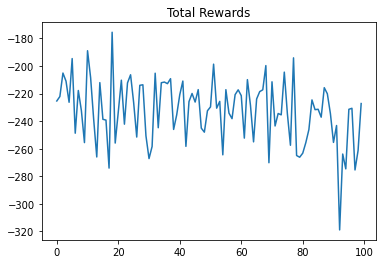

In [11]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

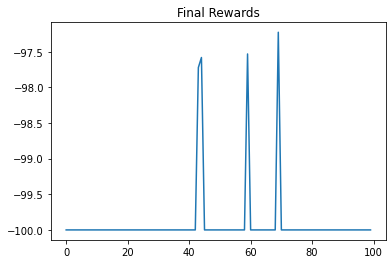

In [12]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

### Test